In [1]:
from pathlib import Path
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from topex import Topex

In [2]:
land_mask = Path('/home/manvel/EO_data/landmask/OSM_ZEE_Iberia_buff.shp')
print(land_mask.is_file())

True


In [4]:
work_dir = Path().cwd()
dem_path = work_dir / 'data/LX_DEM_50m_res.tif'
src = rio.open(dem_path)
dem = src.read(1)
profile = src.profile
# If DEM contains sea, and land area doesn't have 0m values, we can use this
# masking to remove topex effect on the water areas
land_mask = dem==0.
sea_mask = ~land_mask

In [23]:
R = 6_371_000  # m (Average Earth radius)
DEGREE_LENGTH = 2 * np.pi * R / 360
# image res in meters
# NOTE: In this particular case DEM .tif file is in WGS CRS, not projected
#       And the pixel resolution on both directions are practically the same
src.res

(0.0004999999999999999, 0.0005000000000000006)

In [24]:
res = src.res[1] * DEGREE_LENGTH
max_distance = 2000 # meters. The farthest distance to calculate the max slope. Initial version was 2000m
interval = 100 # meters. The intervals to iteretively chekc for max slope angle

In [25]:
topex = Topex(dem, max_distance, interval, y_res=resolution_y_x[0], x_res=resolution_y_x[1])
topex_all = topex.all_dir_multip() # multiproc w/o shared_memory
topex_name = ['TOPEX_N', 'TOPEX_NE', 'TOPEX_E', 'TOPEX_SE', 'TOPEX_S', 'TOPEX_SW', 'TOPEX_W', 'TOPEX_NW']

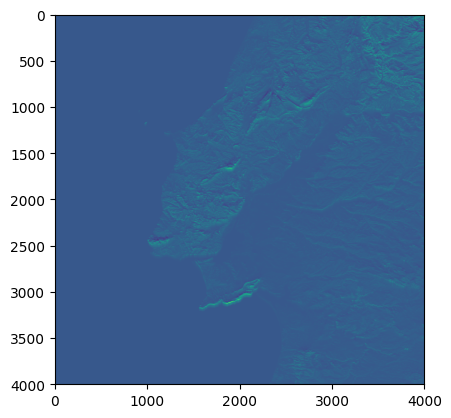

In [14]:
plt.imshow(topex_all[0])